# `nb08`: Coordinate Ascent Variational Inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MovieLens 100k dataset
data = np.loadtxt("data/movielens.csv", dtype=int)
user_ids = data[:, 0] - 1  # user IDs start from 1
item_ids = data[:, 1] - 1  # item IDs start from 1
ratings = data[:, 2]

num_users = 943
num_items = 1682

user_items = [np.where(user_ids == u)[0] for u in range(num_users)]
item_users = [np.where(item_ids == i)[0] for i in range(num_items)]

In [3]:
# Hyperparameters
num_factors = 20
num_iterations = 10

alpha = 2.0  # precision of the noise (1 / sigma^2)
beta = 2.0   # precision of the priors on user/item factors (1 / sigma_u^2, 1 / sigma_v^2)
mu_0 = 0.0   # prior mean for user/item factors

# Initialize variational parameters
user_means = np.random.normal(0, 0.1, (num_users, num_factors))
user_covs = np.array([np.eye(num_factors) for _ in range(num_users)])
item_means = np.random.normal(0, 0.1, (num_items, num_factors))
item_covs = np.array([np.eye(num_factors) for _ in range(num_items)])

In [4]:

# CAVI algorithm
elbo_history = []
rmse_history = []

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Update user factors
    for u in range(num_users):
        indices = user_items[u]
        if len(indices) == 0:
            user_means[u] = mu_0
            user_covs[u] = (1.0 / beta) * np.eye(num_factors)
            continue
        
        items_u = item_ids[indices]
        ratings_u = ratings[indices]
        
        Lambda_u = beta * np.eye(num_factors)
        for idx, i in enumerate(items_u):
            Lambda_u += alpha * (np.outer(item_means[i], item_means[i]) + item_covs[i])
        
        h_u = beta * mu_0 * np.ones(num_factors)
        for idx, i in enumerate(items_u):
            h_u += alpha * ratings_u[idx] * item_means[i]
        
        user_covs[u] = np.linalg.inv(Lambda_u)
        user_means[u] = user_covs[u] @ h_u

    # Update item factors
    for i in range(num_items):
        indices = item_users[i]
        if len(indices) == 0:
            item_means[i] = mu_0
            item_covs[i] = (1.0 / beta) * np.eye(num_factors)
            continue
        
        users_i = user_ids[indices]
        ratings_i = ratings[indices]
        
        Lambda_i = beta * np.eye(num_factors)
        for idx, u in enumerate(users_i):
            Lambda_i += alpha * (np.outer(user_means[u], user_means[u]) + user_covs[u])
        
        h_i = beta * mu_0 * np.ones(num_factors)
        for idx, u in enumerate(users_i):
            h_i += alpha * ratings_i[idx] * user_means[u]
        
        item_covs[i] = np.linalg.inv(Lambda_i)
        item_means[i] = item_covs[i] @ h_i

    # Compute ELBO
    elbo = 0.0
    
    # Likelihood term
    for n in range(len(ratings)):
        u = user_ids[n]
        i = item_ids[n]
        r_ui = ratings[n]
        
        # E[r_ui | u, i]
        expected_r = user_means[u] @ item_means[i]
        
        # E[(r_ui - u^T i)^2]
        expected_sq_error = (r_ui - expected_r) ** 2
        expected_sq_error += user_means[u] @ item_covs[i] @ user_means[u]
        expected_sq_error += item_means[i] @ user_covs[u] @ item_means[i]
        expected_sq_error += np.trace(user_covs[u] @ item_covs[i])
        
        elbo += -0.5 * alpha * expected_sq_error
        elbo += 0.5 * np.log(alpha / (2 * np.pi))
    
    # KL divergence for users
    for u in range(num_users):
        # -KL(q(u) || p(u)) where q ~ N(μ_u, Σ_u), p ~ N(μ_0·1, β^(-1)·I)
        diff = user_means[u] - mu_0
        elbo += -0.5 * beta * (diff @ diff + np.trace(user_covs[u]))
        elbo += 0.5 * np.linalg.slogdet(user_covs[u])[1]
        elbo += 0.5 * num_factors * (np.log(beta / (2 * np.pi)) + 1)

    # KL divergence for items
    for i in range(num_items):
        # -KL(q(i) || p(i)) where q ~ N(μ_i, Σ_i), p ~ N(μ_0·1, β^(-1)·I)
        diff = item_means[i] - mu_0
        elbo += -0.5 * beta * (diff @ diff + np.trace(item_covs[i]))
        elbo += 0.5 * np.linalg.slogdet(item_covs[i])[1]
        elbo += 0.5 * num_factors * (np.log(beta / (2 * np.pi)) + 1)

    elbo_history.append(elbo)
    print(f"ELBO: {elbo:.4f}")
        
    # Compute train RMSE
    predictions = np.array([user_means[user_ids[n]] @ item_means[item_ids[n]] 
                           for n in range(len(ratings))])
    train_rmse = np.sqrt(np.mean((ratings - predictions) ** 2))
    
    rmse_history.append(train_rmse)
    print(f"Train RMSE: {train_rmse:.4f}\n")

print("\nTraining complete!")


Iteration 1/10
ELBO: -1200702.8626
Train RMSE: 2.9290

Iteration 2/10
ELBO: -314241.8678
Train RMSE: 0.8960

Iteration 3/10
ELBO: -265079.8872
Train RMSE: 0.7590

Iteration 4/10
ELBO: -247288.9939
Train RMSE: 0.7006

Iteration 5/10
ELBO: -238192.7505
Train RMSE: 0.6698

Iteration 6/10
ELBO: -232316.7600
Train RMSE: 0.6512

Iteration 7/10
ELBO: -227996.7040
Train RMSE: 0.6387

Iteration 8/10
ELBO: -224599.2479
Train RMSE: 0.6296

Iteration 9/10
ELBO: -221832.0231
Train RMSE: 0.6229

Iteration 10/10
ELBO: -219534.9659
Train RMSE: 0.6176


Training complete!


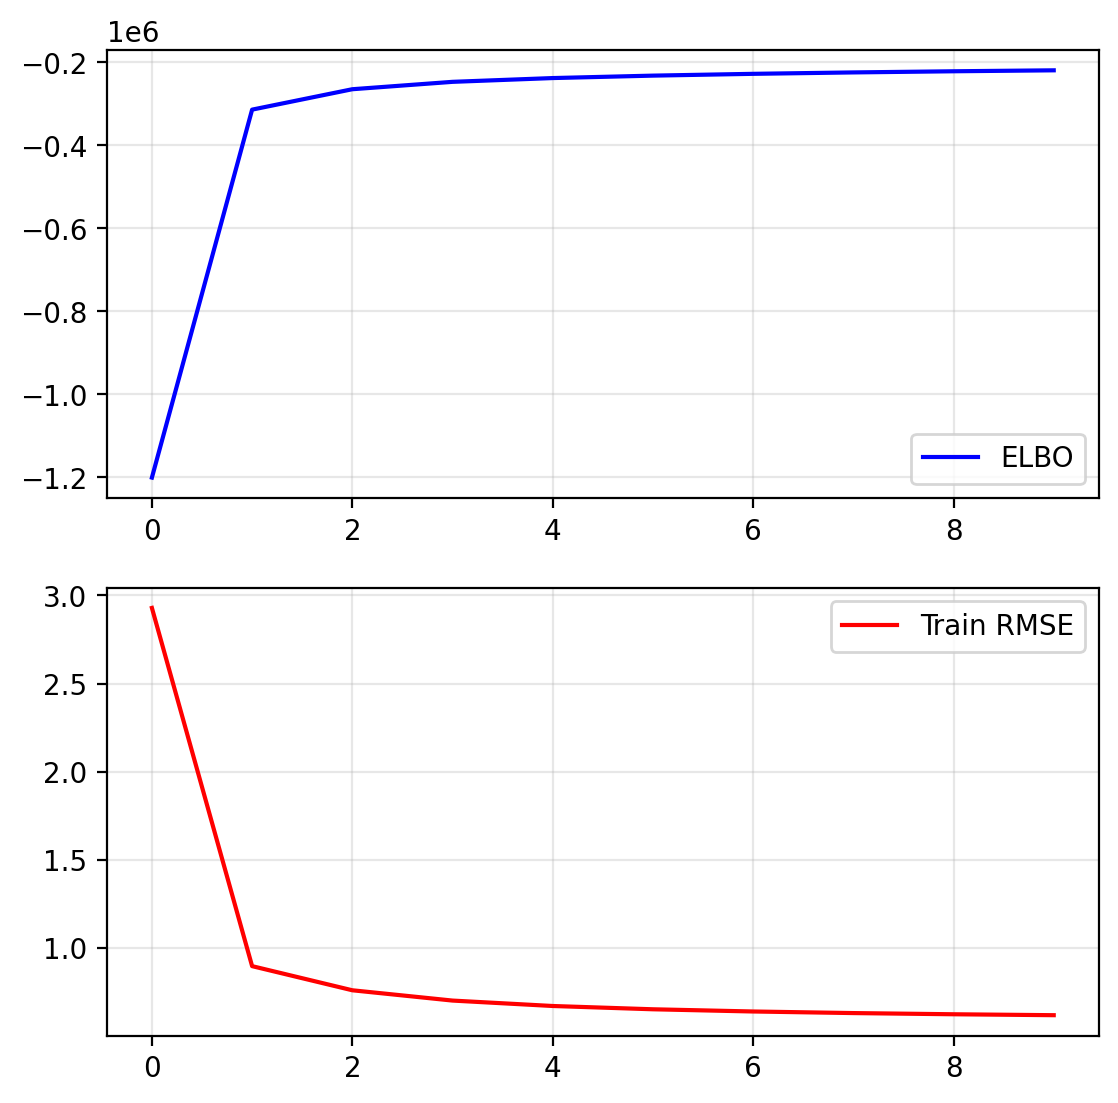

In [5]:

# Convergence plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 6.4), dpi=200)

ax1.plot(elbo_history, "b-", label='ELBO')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(rmse_history, "r-", label='Train RMSE')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.savefig("figures/lec8/cavi-convergence.png")
plt.show()


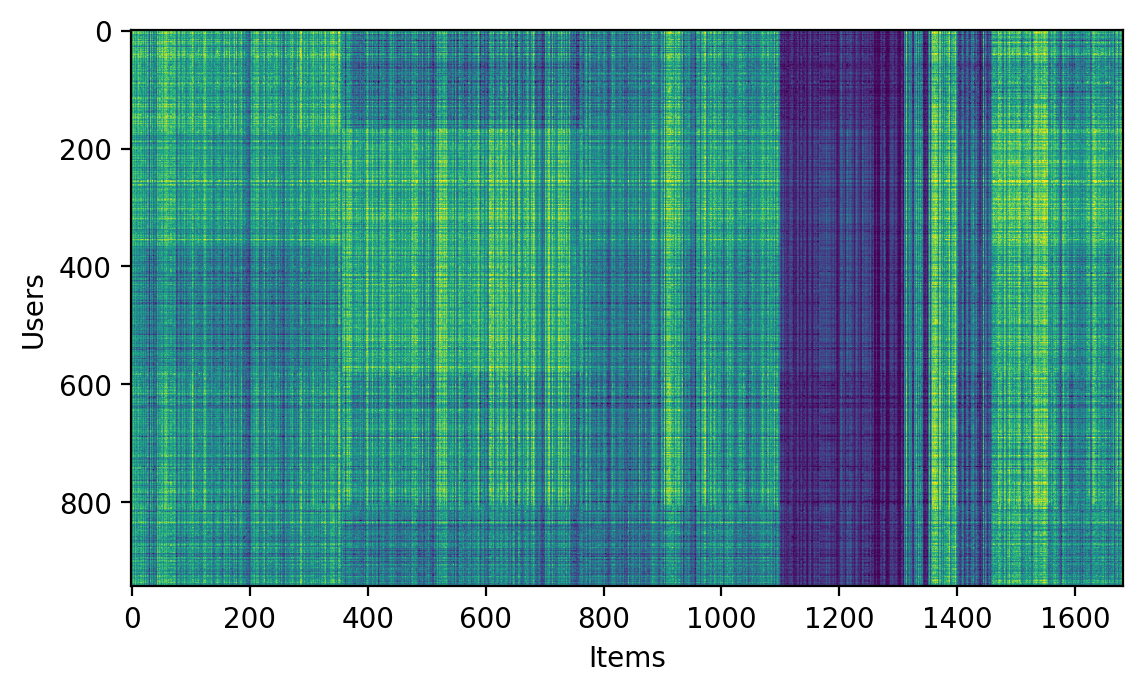

In [ ]:
# Predict ratings
predicted_ratings = np.array([[user_means[u] @ item_means[i] for i in range(num_items)] for u in range(num_users)])

# Biclustering reordering
from sklearn.cluster import SpectralBiclustering
model = SpectralBiclustering(n_clusters=5, random_state=0)
model.fit(predicted_ratings)
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
predicted_ratings = predicted_ratings[np.ix_(row_order, col_order)]

# Plot ratings matrix
plt.figure(figsize=(6.4, 6.4), dpi=200)
plt.imshow(predicted_ratings, cmap='viridis', vmin=0, vmax=5)
plt.xlabel("Items")
plt.ylabel("Users")
plt.savefig("figures/lec8/cavi-predicted-ratings.png")
plt.show()
